<h1>For extracting features from audio</h1>

In [19]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [10]:
data_dir = '../../IEMOCAP_full_release/'
labels_df_path = '{}dialog_EmoEvaluation_labels.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_5.pkl'.format(data_dir)

In [11]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [12]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

In [14]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

AttributeError: module 'librosa.display' has no attribute 'waveplot'

<Figure size 1500x200 with 0 Axes>

<Figure size 1500x200 with 0 Axes>

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [15]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = nan
Signal std dev = nan


/home/neel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/neel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/neel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/neel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/neel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


RMSE mean = 0.00000
RMSE std dev = 0.00000


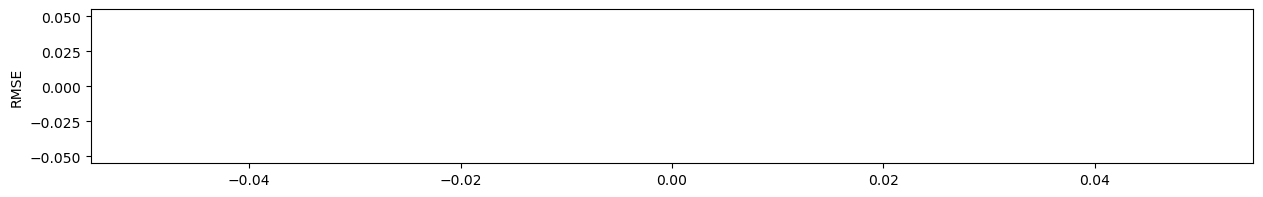

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [20]:
rmse = librosa.feature.rms(y=(y + 0.0001))[0]
plt.figure(figsize=(15, 2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [21]:
from IPython.display import Audio
Audio(y, rate=44100)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
silence = 0
for e in rmse:
    if e <=0.4*np.mean(rmse):
        silence +=1
print(silence/float(len(rmse)))

In [ ]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

In [ ]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

In [ ]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >=cl:
        center_clipped.append(s-cl)
    elif s<=-cl:
        center_clipped.append(s+cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

In [ ]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [ ]:
emotion_dict = {
    'ang': 0,
    'hap': 1,
    'exc': 2,
    'sad': 3,
    'fru': 4,
    'fea': 5,
    'sur': 6,
    'neu': 7,
    'xxx': 8,
    'oth': 8
}

label_path = '../../IEMOCAP_full_release/dialog_EmoEvaluation_labels.csv'
audio_vectors = '../../IEMOCAP_full_release/audio_vectors_5.pkl'

In [ ]:
labels_df = pd.read_csv(label_path)

for sess in (range(1, 6)):
    audio_vectos = pickle.load(open(audio_vectors), 'rb')
    for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
        try:
            wav_file_name = row['wav_file']
            label = emotion_dict[row['emotion']]
            y = audio_vectos[wav_file_name]
            
            feature_list = [wav_file_name, label] # wav_file, label
            sig_mean = np.mean(abs(y))
            feature_list.append(sig_mean)
            feature_list.append(np.std(y))
            
            rmse = librosa.feature.rms(y + 0.0001)[0]
            feature_list.append(np.mean(rmse))
            feature_list.append(np.std(rmse))
            
            silence = 0
            for e in rmse:
                if e <= 0.4 * np.mean(rmse):
                    silence +=1
            silence /= float(len(rmse))
            feature_list.append(silence)
            
            y_harmonic = librosa.effects.hpss(y)[0]
            feature_list.append(np.mean(y_harmonic) * 1000) # Harmonic scaled by 1000
            
            # based on the pitch detection algorithm mentioned here:
            # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
            cl = 0.45 * sig_mean
            center_clipped = []
            for s in y:
                if s >= cl:
                    center_clipped.append(s-cl)
                elif s<= -cl:
                    center_clipped.append(s+cl)
                elif np.abs(s) < cl:
                    center_clipped.append(0)
            
            auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
            feature_list.append(1000* np.max(auto_corrs)/ len(auto_corrs))
            feature_list.append(np.std(auto_corrs))
            
            df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_inde=True)
        except:
            print('Some exception occured')
            
df_features.to_csv('../../IEMOCAP_full_release/audio_features.csv', index=False)